# [BioMed@DataScience](https://thetahat.ru/courses/bm-2025-spr)
## Домашнее задание 5

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@thetahat_bmds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Решение проверяется системой ИИ-проверки <a href="https://thetahat.ru/"><img src="https://miptstats.github.io/theta_grader_small.png" style="display: inline; vertical-align: middle;"></a> **ThetaGrader**. Результат проверки валидируется и исправляется человеком, после чего комментарии отправляются студентам.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash; 50 баллов
* Задача 2 &mdash; 30 баллов
* Задача 3 &mdash; 20 баллов
-----

In [ ]:
# Bot check

# HW_ID: bmds_hw5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GroupShuffleSplit

import warnings
import seaborn as sns
sns.set_theme(palette='Set2')
warnings.filterwarnings("ignore")

#### <b><font color="blue">Легкая часть</font></b>

### Задача 1


#### 1. Загрузка данных и предобработка

Загрузите данные по предсказанию рака груди. Подробнее о них можно почитать в [источнике](https://www.kaggle.com/datasets/marshuu/breast-cancer).


In [ ]:
data = pd.read_csv('breast_cancer.csv')
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


Проверьте, имеются ли в ваших данных пропуски. Если да, то удалите их.


In [ ]:
data.isna().sum()

data = data.dropna()

Библиотека `pandas` позволяет строить графики `matplotlib` для своих объектов `DataFrame` ([подробнее](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)). Посмотрим, как распределены значения признака `Bare Nuclei` для разных классов:

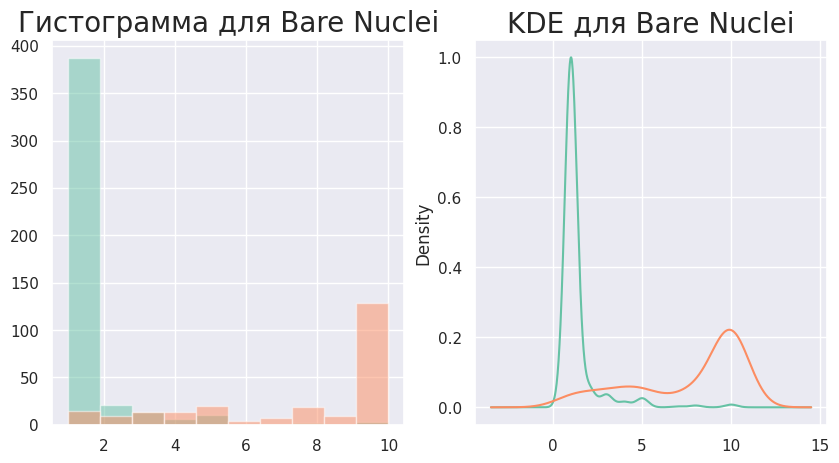

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Bare Nuclei'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Bare Nuclei'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Bare Nuclei', fontsize=20)
axs[1].set_title('KDE для Bare Nuclei', fontsize=20);

Чем отличаются способы построения ЯОП и гистограммы? Какую информацию о наших данных можно извлечь из каждого графика?

**Ответ:** Гистограмма показывает дискретное распределение, мы можем увидеть результат для отдельных интервалов значений. ЯОП сглаживает распределение, поэтому можно более точно определить результат. Если сравнивать, то по ЯОП четче видны пики и пересечения между разными признаками.

Из гистограммы для Bare Nuclei можно извлечь, что для доброкачественных опухолей в большинстве случаев параметр Bare Nuclei равен 1, для злокачественных многие имеют параметр 10, остальные примерно равномерно распределены от 1 до 9. Из ЯОП для Bare Nuclei видно что для доброкачественных опухолей значение 1 встречается также чаще всего, но также встречаются значения от 2 до 5, затем график спадает. Для злокачественных график имеет максимум на 10, далее спускается и плавно спадает от 5 до 1. В целом информация одна и та же, но из ЯОП более точная.

Постройте гистограммы и ядерные оценки плотности для всех признаков из датасета отдельно для каждого класса. `Class` — целевая переменная. Можно это сделать, опираясь на код выше, а можно воспользоваться параметром `hue` у функции [`sns.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) или другим методом, который вам нравится. Не забывайте подписывать, к чему относится каждый график.

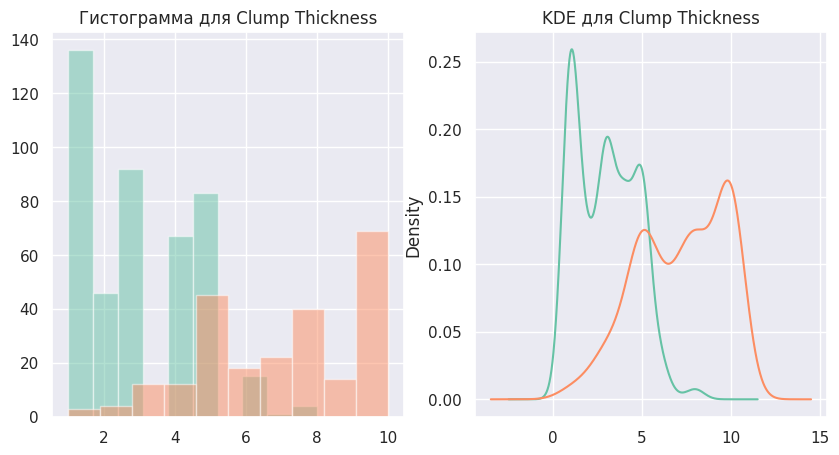

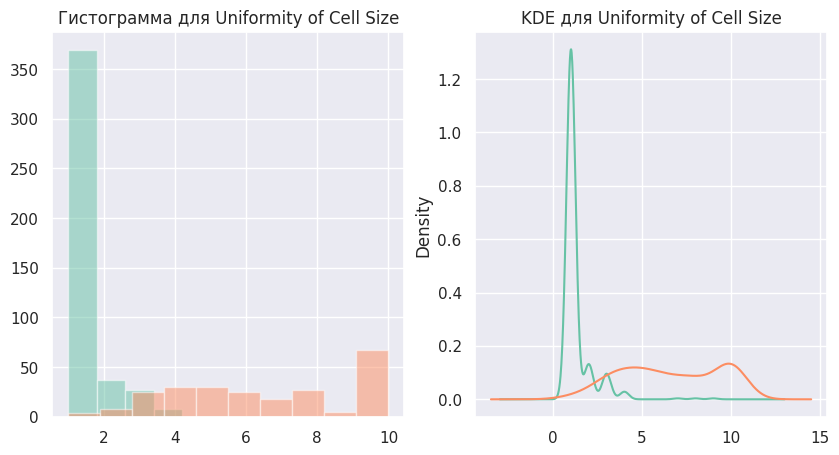

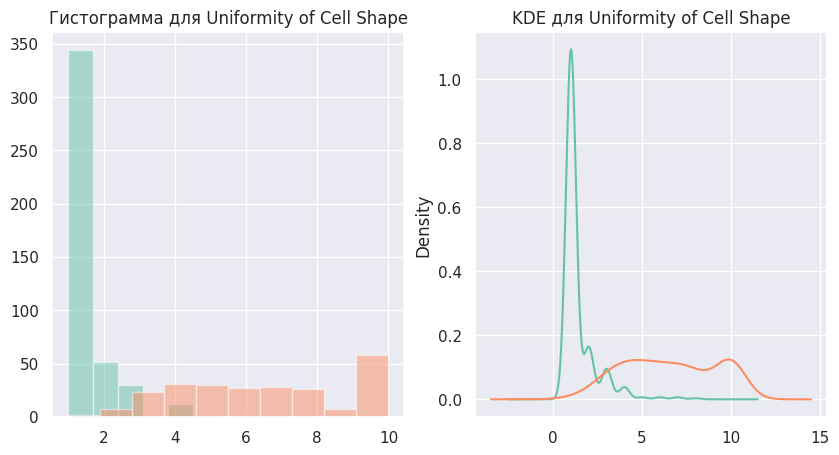

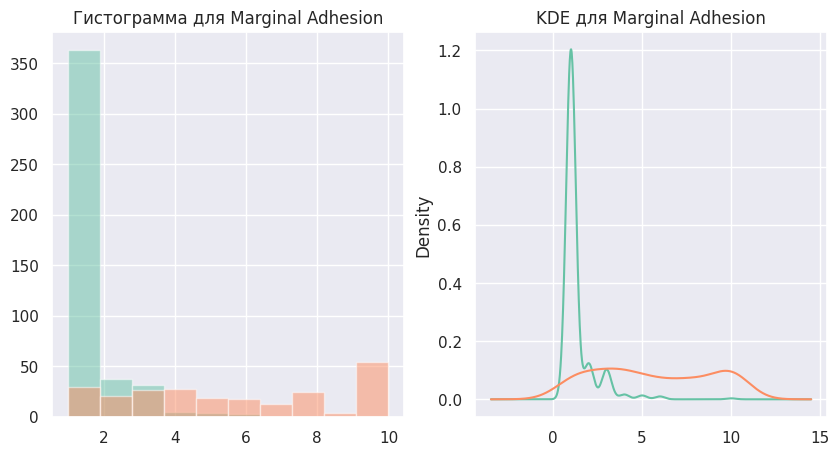

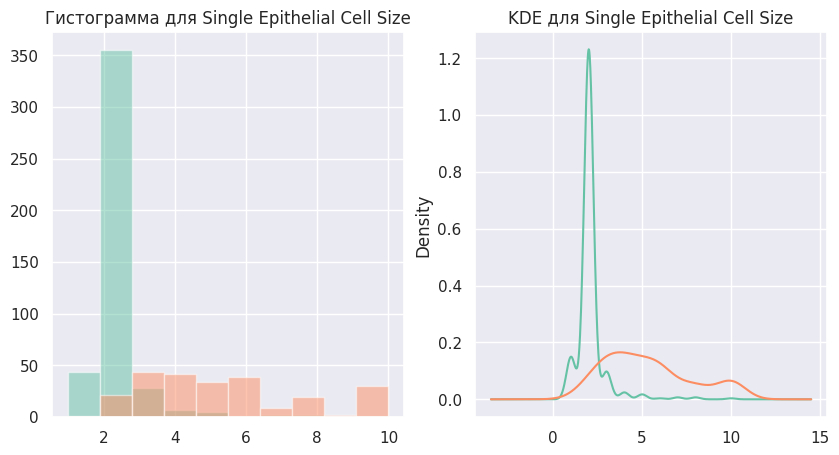

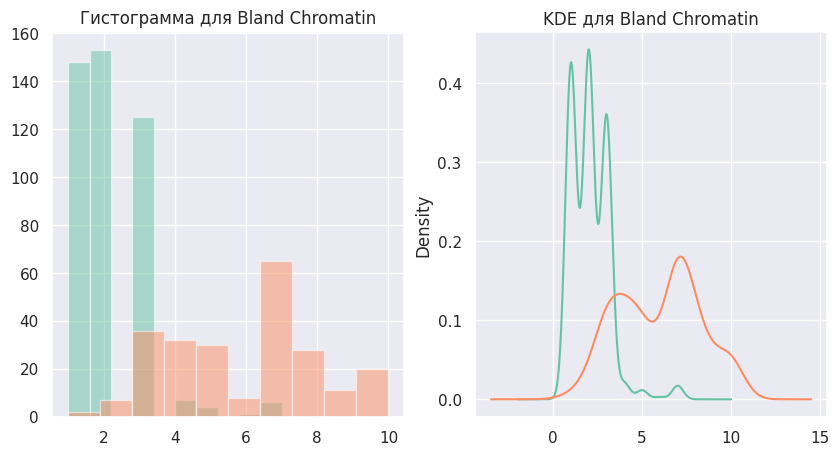

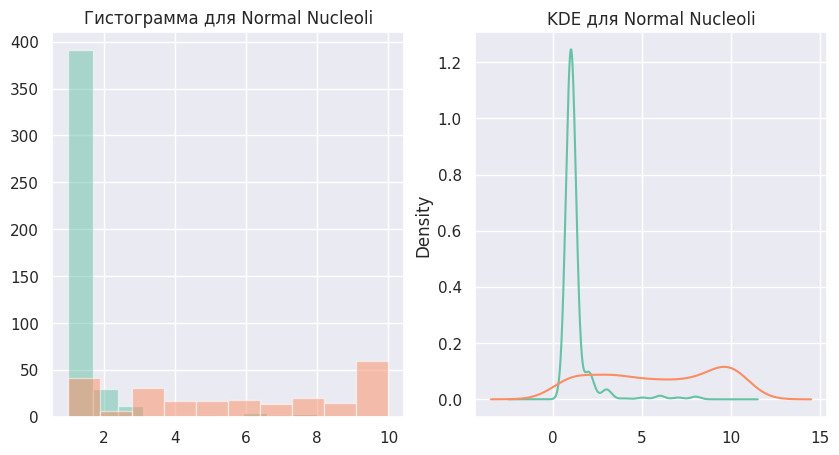

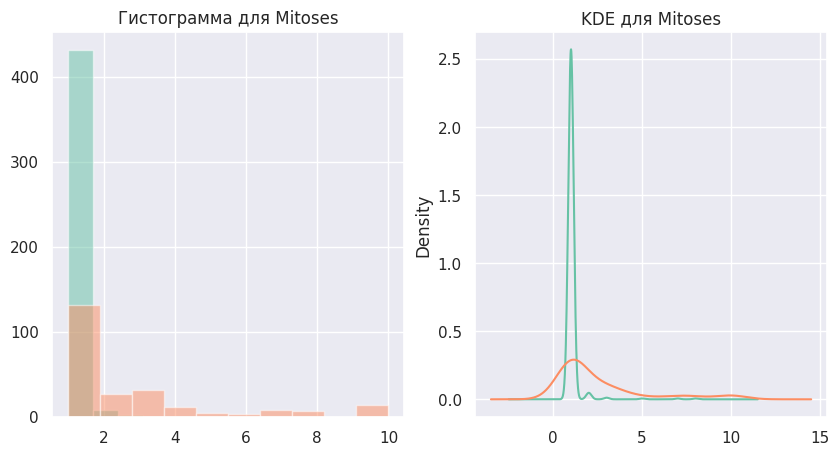

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Clump Thickness'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Clump Thickness'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Clump Thickness', fontsize=12)
axs[1].set_title('KDE для Clump Thickness', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Uniformity of Cell Size'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Uniformity of Cell Size'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Uniformity of Cell Size', fontsize=12)
axs[1].set_title('KDE для Uniformity of Cell Size', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Uniformity of Cell Shape'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Uniformity of Cell Shape'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Uniformity of Cell Shape', fontsize=12)
axs[1].set_title('KDE для Uniformity of Cell Shape', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Marginal Adhesion'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Marginal Adhesion'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Marginal Adhesion', fontsize=12)
axs[1].set_title('KDE для Marginal Adhesion', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Single Epithelial Cell Size'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Single Epithelial Cell Size'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Single Epithelial Cell Size', fontsize=12)
axs[1].set_title('KDE для Single Epithelial Cell Size', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Bland Chromatin'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Bland Chromatin'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Bland Chromatin', fontsize=12)
axs[1].set_title('KDE для Bland Chromatin', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Normal Nucleoli'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Normal Nucleoli'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Normal Nucleoli', fontsize=12)
axs[1].set_title('KDE для Normal Nucleoli', fontsize=12);

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby("Class")['Mitoses'].hist(ax=axs[0], alpha=0.5)
data.groupby("Class")['Mitoses'].plot(kind='kde', ax=axs[1])
axs[0].set_title('Гистограмма для Mitoses', fontsize=12)
axs[1].set_title('KDE для Mitoses', fontsize=12);

Какие выводы вы можете сделать из полученных графиков?

**Вывод:** 1) для всех признаков доброкачественные опухоли находятся по большей части в области низких значений (1-3), злокачественные наоборот (6-10).

2) злокачественные распределены по большему диапазоны значений, доброкачественные сконцентрированы в одном месте (поэтому высокий пик).

3) Наиболее информативными можно назвать Uniformity of Cell Size, Uniformity of Cell Shape, Bare Nuclei, т.к. там наблюдается максимальное разделение между классами.

**Это не конец задачи! Переходите к пункту 2!**

#### 2. Обучение модели

Продолжайте использовать выбранные вами данные.

Создайте массив признаков и массив таргета. Разбейте ваши данные на обучающую и тестовую выборки в отношении 7:3.


In [ ]:
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**Ответ:**

Обучите модель логистической регрессии.

In [29]:
model = LogisticRegression(fit_intercept=True, penalty=None)
model.fit(X_train, y_train)

LogisticRegression(penalty=None)

Сделайте предсказание для тестовой выборки и оцените качество модели.

In [30]:
y_pred = model.predict(X_test)
print('Accuracy =',accuracy_score(y_test, y_pred))
print('MAPE =', mean_absolute_percentage_error(y_test, y_pred))

Accuracy = 0.9560975609756097
MAPE = 0.03414634146341464


Можно ли порадоваться таким результатам? Вернемся к гистограммам и сделаем вывод, почему метрики оказались такими большими.

#### 3. Учтём дисбаланс классов
Давайте посмотрим на распределение наших данных по целевой переменной по всему датасету, тренировочной и тестовой выборкам:

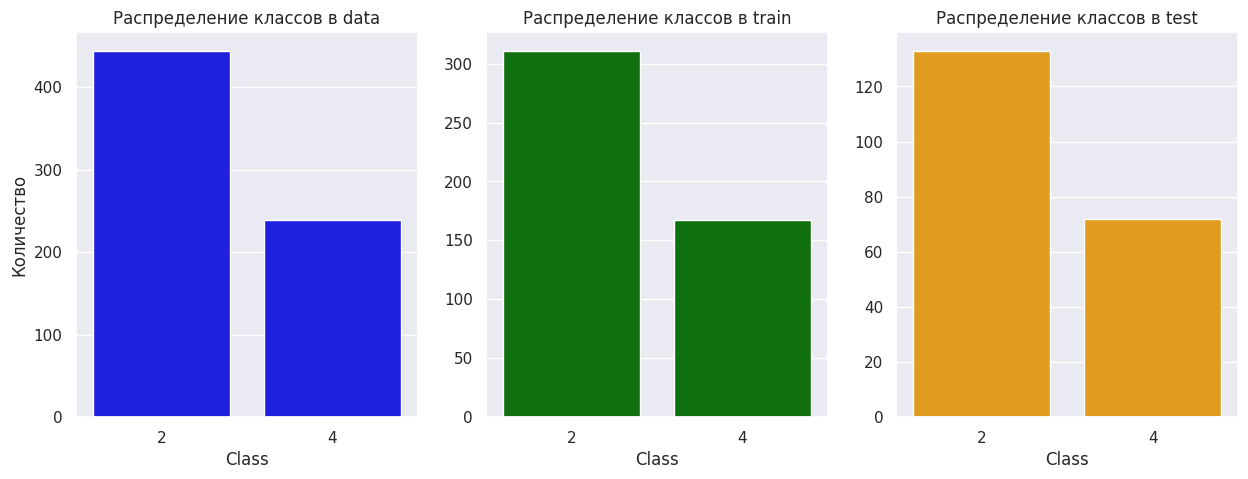

In [31]:
original = data['Class'].value_counts() # Колонка таргета из всего датасета
train = y_train.value_counts() # Колонка таргета из тренировочной выборки
test = y_test.value_counts() # Колонка таргета из тестовой выборки

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=original.index, y=original.values, ax=axes[0], palette=['blue'])
axes[0].set_title('Распределение классов в data')
axes[0].set_ylabel('Количество')

sns.barplot(x=train.index, y=train.values, ax=axes[1], palette=['green'])
axes[1].set_title('Распределение классов в train')

sns.barplot(x=test.index, y=test.values, ax=axes[2], palette=['orange'])
axes[2].set_title('Распределение классов в test');

Видно, что в данных есть сильный перекос — классы представлены неравномерно. Как и почему это повлияло на наши результаты?

**Ответ:** Так как одного из классов у нас больше во всех выборках - модель обучается так, что видит только 1 класс и старается отнести большую чать данных к нему. Это не слильно повляло на наши результаты, так как в тестовой выборке наблюдается такое же превосходство 1 класса над 2. В целом такой поход может привести к затруднению определения второго класса на в те моменты, когда мы хотим в модель поместить данные с равным количеством элементов того или иного класса, так как модель будет игнорировать второй класс.

Есть много способов борьбы с этим. Можно искусственно сгенерировать данные нужного класса или урезать другой класс. Однако сегодня мы воспользуемся ***взвешенной*** логистической регрессией. Суть метода заключается в том, чтобы вручную поставить веса для классов, исходя из их предполагаемой природы: важность разных классов, цена ошибки в реальной жизни (например, что хуже: предсказать наличие рака, если он есть или нет?) и представленность данных.

Функция потерь &mdash; в нашем случае логарифм функции правдоводобия, взятый со знаком минус &mdash; для взвешенной логистической регрессии будет записана как:

$$
L(y, \widehat{y}) = -\sum_{i=1}^{N} w_{y_i} \cdot \left[ y_i \cdot \log(\sigma(\widehat{y}_i)) + (1 - y_i) \cdot \log(1 - \sigma(\widehat{y}_i)) \right]
$$
где:

- $ y_i $ - истинный класс для образца  $i$;
- $ \widehat{y}_i $ - предсказанный класс для образца $i$;
- $ w_{y_i} $ - вес класса;
- знак минус служит для сведения задачи к поиску минимума; задача минимизации несколько более типична для машинного обучения.



Давайте реализуем этот метод. Допишите код, в качестве весов класса  поставьте соотношение их представленности. Выведите подсчет количества экземпляров каждого класса и посчитайте их соотношение.

In [32]:
threshold = original.values[0] / (original.values[0] + original.values[1])
class_weights = {
    4: threshold,
    2: 1 - threshold
    }
# если использовать class_weights = 'balanced', модель сама подсчитает веса
print(threshold)

0.6500732064421669


In [ ]:
weighted_model = LogisticRegression(class_weight=class_weights)

Посчитайте `Accuracy` двумя способами: без учёта и [с учётом весов](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html).

In [33]:
weighted_model = LogisticRegression(class_weight=class_weights)
weighted_model.fit(X_train, y_train)

LogisticRegression(class_weight={2: np.float64(0.34992679355783307),
                                 4: np.float64(0.6500732064421669)})

In [34]:
y_predWeigth = weighted_model.predict(X_test)

AccuracyWithOutWeight = accuracy_score(y_test, y_pred)
AccuracyWithWeigth = accuracy_score(y_test, y_predWeigth)
print('AccuracyWithOutWeight = ', AccuracyWithOutWeight)
print('AccuracyWithWeigth = ', AccuracyWithWeigth)

AccuracyWithOutWeight =  0.9560975609756097
AccuracyWithWeigth =  0.9658536585365853


Как изменилось качество нашей модели? Почему надо учитывать несбалансированность данных?

Сделайте общий вывод по задаче.

**Вывод:** Модель стала лучше предсказывать, так как стала лучше видеть различие между классами.

Без учета несбалансированности данных мы можем попасть в ту ситуацию, что модель училась на таких несбалансированных данных и, соответственно, не научилась с достаточной точность определять второй класс.

Например, если наша модель училась на данных 2000 года инфекционных заболеваний, то она бы училась на заболевании - 'Грипп' и прочих инфекуционных забалеваниях, но грипп был бы в подавляющем большинство. И тогда, например, в момент эпидемии 2020 короновируса по симптоматике пациентов она бы присваивала им заболевание - 'Грипп', а не короновирус, даже если предположить, что коронавирус был и в 2000, только более редок.

В этой задаче мы поняли, что очень важно учитывать сбалансированность классов, так как в случае несоблюдения этого модель будет хуже предсказывать другой класс, стараясь предсказывать больше тот класс, который был в обучающей модели в большинстве

---
### Задача 2

*Перед выполнением задачи ознакомтесь с <a href="https://thetahat.ru/courses/bm-ds-2025-aut">ноутбуком по логистической регрессии</a> с занятия.*

> Одно из интересных свойств модели логистической регрессии — *при соблюдении её предположений* она дает возможность получать **несмещенные оценки вероятностей** принадлежности объекта к определенному классу.  
> Для пояснения рассмотрим объект $x$ и соответствующее предсказание вероятности $\widehat{p}(x)$ для класса 1. Если взять небольшую окрестность объекта $x$, то доля объектов класса 1 в этой окрестности будет приблизительно равна $\widehat{p}(x)$.  

Далее проверим это свойство на конкретных примерах.

С помощью кода ниже сгенерируйте данные, состоящие из одного вещественного признака и бинарного таргета.

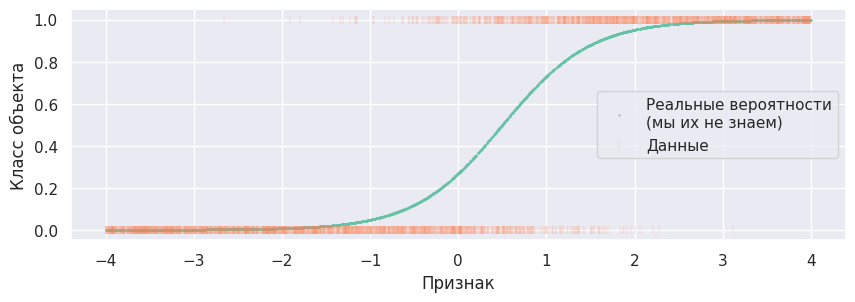

In [ ]:
sample_size = 3000  # Размер выборки

# Признаки
X = np.random.uniform(low=-4, high=4, size=(sample_size, 1))

# Таргет
y_mean_true = 1 / (1 + np.exp(1 - 2 * X.ravel()))
y = np.random.binomial(n=1, p=y_mean_true)

plt.figure(figsize=(10, 3))
plt.scatter(X, y_mean_true, marker=".", s=1, label="Реальные вероятности\n(мы их не знаем)")
plt.scatter(X, y, marker="|", alpha=0.1, label="Данные")
plt.xlabel("Признак")
plt.ylabel("Класс объекта")
plt.legend();

Обучите логистическую регрессию, используя реализацию из `sklearn`, при этом свободный коэффициент должен присутствовать в модели. Укажите также `penalty='none'`.

In [ ]:
model = LogisticRegression(penalty=None, fit_intercept=True)
model.fit(X_train, y_train)

Напечатайте оценку коэффициентов

In [36]:
model.coef_

array([[0.5198541 , 0.29788721, 0.31861483, 0.29596381, 0.19057231,
        0.64317136, 0.12928085, 0.18839903, 0.71346768]])

Ниже объявлена сетка значений признака. По этой сетке постройте
* предсказания классов,
* предсказания вероятностей класса 1.

Визуализируйте эти предсказания. На график стоит нанести также обучающую выборку.

In [37]:
X_grid = np.linspace(-4, 4, 10000).reshape((-1, 1))
y_prob_grid = model.predict_proba(X_grid)[:, 1]
y_class_grid = model.predict(X_grid)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X, y, marker="|", alpha=0.1, label="Обучающая выборка")
plt.plot(X_grid, y_prob_grid, color='red', linewidth=2, label="Предсказанные вероятности")
plt.plot(X_grid, 1/(1 + np.exp(1 - 2 * X_grid.ravel())), 'g--', alpha=0.7, label="Реальные вероятности")
plt.xlabel("Признак")
plt.ylabel("Вероятность класса 1")
plt.title("Предсказания вероятностей")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X, y, marker="|", alpha=0.1, label="Обучающая выборка")
plt.plot(X_grid, y_class_grid, color='blue', linewidth=2, label="Предсказанные классы")
plt.xlabel("Признак")
plt.ylabel("Класс")
plt.title("Предсказания классов")
plt.legend()

plt.tight_layout()
plt.show()

ValueError: X has 1 features, but LogisticRegression is expecting 9 features as input.

Разбейте отрезок $[-4, 4]$ на одинаковые бины длины длины 0.2 и посчитайте в каждом бине долю объектов класса 1. Полученные значения добавьте на график предсказаний вероятностей и сравните эти графики. Проинтерпретируйте полученные результаты.

*Подсказка:* может помочь `np.digitize` и метод `groupby` для таблиц `pandas`. Рекомендуем посмотреть <a href="https://thetahat.ru/courses/python">обучающие ноутбуки</a> по библиотекам.

In [ ]:
<...>

Повторите проведенное исследование для следующих данных и сравните результаты.

In [ ]:
# Признаки
X = np.random.uniform(low=-4, high=4, size=(sample_size, 1))

# Таргет
y_mean_true = 1 / (1 + np.exp(-100 * X.ravel()))
y = np.random.binomial(n=1, p=y_mean_true)

plt.figure(figsize=(10, 3))
plt.scatter(X, y_mean_true, marker=".", s=1, label="Реальные вероятности")
plt.scatter(X, y, marker="|", alpha=0.1, label="Данные")
plt.xlabel("Признак")
plt.ylabel("Класс объекта")
plt.legend();

**Выводы:**

...

---
### Задача 3.


Продолжим исследовать модель логистической регрессии. Сгенерируем данные, состоящие из двух бинарных признаков и бинарного таргета

In [ ]:
probs = np.random.uniform(size=8)
probs /= probs.sum()
probs

x = np.random.choice(np.arange(8), p=probs, size=10000)
data = pd.DataFrame(
    np.unpackbits(np.array(x.reshape(-1, 1), dtype=">i8").view(np.uint8), axis=1)[:, -3:],
    columns=["feature_1", "feature_2", "target"],
)
data.head()

Особенность таких данных &mdash; конечное число *возможных различных* объектов. В данном случае их всего 4, по количеству всех возможных комбинаций значений признака. Соответственно, любой моделью мы можем сделать только 4 *различных* предсказания. Исследуем, как с этим справляется логистическая регрессия.

Сначала для сравнения посчитайте долю класса 1 для каждой категории объектов.

*Подсказка:* используйте `pd.pivot_table`. Рекомендуем посмотреть <a href="https://thetahat.ru/courses/python">обучающие ноутбуки</a> по библиотекам.

In [ ]:
<...>


Обучите логистическую регрессию с `penalty='none'` и получите предсказания вероятностей для этих четырех типов объектов. Представьте результаты в таком виде, чтобы их удобно было сравнивать с частотами, посчитанными ранее.

<...>

Почему результаты не совпадают?

Для ответа на этот вопрос распишите формулу, которая задает модель логистической регрессии, указав все параметры. Какое предположение о данных при этом делает логистическая регрессия?

...

Предложите и реализуйте способ построения модели логистической регрессии так, чтобы она точнее предсказывала частоты, посчитанные ранее.
Опишите ваше предложение:


...

Реализация:

In [ ]:
...

**Выводы:**

...

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для BioMed@DataScience